In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda:0 is available


### Get Image Path

In [4]:
import os

PATH = 'Data/'
HR_list = os.listdir(PATH + 'HR/')
print("Image cnt : {}".format(len(HR_list)))

LR_list = os.listdir(PATH + 'LR/')
print("Image cnt : {}".format(len(LR_list)))


Image cnt : 100
Image cnt : 100


In [5]:
print(HR_list)

['0.png', '1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '5.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '6.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '7.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '8.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '9.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png']


In [6]:
from PIL import Image
import numpy as np

LR_images = []
for path in LR_list:
    img = Image.open(os.path.join(PATH, 'LR', path))
    img = np.asarray(img)
    LR_images.append(img)

HR_images = []
for path in HR_list:
    img = Image.open(os.path.join(PATH, 'HR', path))
    img = np.asarray(img)
    HR_images.append(img)

LR_images = np.asarray(LR_images)
HR_images = np.asarray(HR_images)

In [7]:
print(f"LR Images shape : {LR_images.shape}")
print(f"HR Images shape : {HR_images.shape}")

LR Images shape : (100, 96, 96, 3)
HR Images shape : (100, 384, 384, 3)


# create B ResidualBlock  


In [8]:
class B_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(B_ResidualBlock, self).__init__()
        
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.PReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
        )
        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels)
            )
    
    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        out = x + out
        return out

# Generator Network

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.in_channels = 64
        self.num_bloacks = 5

        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU()
        )

        self.layer1 = self.make_layer(64, self.num_bloacks, stride=1)    # B_residual blocks
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.layer5 = nn.Conv2d(64, 3, 9, stride=1, padding=4)


    def make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            block = B_ResidualBlock(self.in_channels, out_channels)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        base = self.base(x)         # base : used for 'skip connection'
        layer1 = self.layer1(base)  # layer1 : B_residual blocks
        layer2 = self.layer2(layer1)
        layer2 = layer2 + base      # Elementwise Sum
        
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        return layer5

In [10]:
# model
generator = Generator().to(device)

In [11]:
import torchsummary
torchsummary.summary(generator, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,728
             PReLU-2           [-1, 64, 96, 96]               1
            Conv2d-3           [-1, 64, 96, 96]          36,864
       BatchNorm2d-4           [-1, 64, 96, 96]             128
             PReLU-5           [-1, 64, 96, 96]               1
            Conv2d-6           [-1, 64, 96, 96]          36,864
       BatchNorm2d-7           [-1, 64, 96, 96]             128
   B_ResidualBlock-8           [-1, 64, 96, 96]               0
            Conv2d-9           [-1, 64, 96, 96]          36,864
      BatchNorm2d-10           [-1, 64, 96, 96]             128
            PReLU-11           [-1, 64, 96, 96]               1
           Conv2d-12           [-1, 64, 96, 96]          36,864
      BatchNorm2d-13           [-1, 64, 96, 96]             128
  B_ResidualBlock-14           [-1, 64,

# Discriminator Network

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.in_channels = 64

        self.base = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, padding=1),
            nn.LeakyReLU()
        )
        self.conv_layer1 = self.make_layer(64, 64, 2)
        self.conv_layer2 = self.make_layer(64, 128, 1)
        self.conv_layer3 = self.make_layer(128, 128, 2)
        self.conv_layer4 = self.make_layer(128, 256, 1)
        self.conv_layer5 = self.make_layer(256, 256, 2)
        self.conv_layer6 = self.make_layer(256, 512, 1)
        self.conv_layer7 = self.make_layer(512, 512, 2)

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512 * 6 * 6, 1024, bias=False),
            nn.LeakyReLU()
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(1024, 1, bias=False),
            nn.Sigmoid()
        )
        
        
    def make_layer(self, in_channels, out_channels, stride):
        conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return conv_block

    def forward(self, x):
        out = self.base(x)
        out = self.conv_layer1(out)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.conv_layer5(out)
        out = self.conv_layer6(out)
        out = self.conv_layer7(out)

        out = out.view(out.size(0), -1)
        out = self.fc_layer1(out)
        out = self.fc_layer2(out)
        return out

In [14]:
discriminator = Discriminator().to(device)
torchsummary.summary(discriminator, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
         LeakyReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 48, 48]          36,864
       BatchNorm2d-4           [-1, 64, 48, 48]             128
         LeakyReLU-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,728
       BatchNorm2d-7          [-1, 128, 48, 48]             256
         LeakyReLU-8          [-1, 128, 48, 48]               0
            Conv2d-9          [-1, 128, 24, 24]         147,456
      BatchNorm2d-10          [-1, 128, 24, 24]             256
        LeakyReLU-11          [-1, 128, 24, 24]               0
           Conv2d-12          [-1, 256, 24, 24]         294,912
      BatchNorm2d-13          [-1, 256, 24, 24]             512
        LeakyReLU-14          [-1, 256,

# Loss Function / Content loss

## Generator Test
- Input 데이터를 넣으면 SR 데이터로 업스케일링이 잘 되는지 확인해보장

In [11]:
print(f"LR Images shape : {LR_images.shape}")
print(f"HR Images shape : {HR_images.shape}")

LR Images shape : (100, 96, 96, 3)
HR Images shape : (100, 384, 384, 3)


In [12]:
print(LR_images[0].shape)

(96, 96, 3)


In [13]:
from torch.utils.data import DataLoader

In [14]:
LR_tensor = torch.Tensor(LR_images)
HR_tensor = torch.Tensor(HR_images)

LR_dataloader = DataLoader(LR_tensor)
HR_dataloader = DataLoader(HR_tensor)

In [15]:
len(LR_dataloader)

100

In [16]:
result = []
for data in LR_dataloader:
    inputs = data.to(device)
    outputs = generator(inputs.view(-1, 3, 96, 96))
    result.append(outputs)
    break

print(len(result))

1


In [17]:
import numpy as np

In [18]:
img = np.asarray(result[0].cpu().detach().numpy())


In [19]:
img.shape

(1, 3, 384, 384)

In [20]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


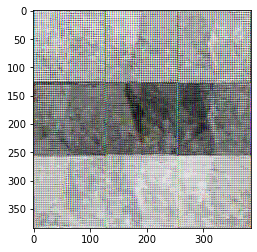

In [21]:

plt.imshow(np.reshape(img, (384, 384, 3)))

